In [41]:
import sys
import os
from typing import List, Dict, Tuple, Any

eval_folder_path = "exp/shadow_sasrec_on_sr_data_lr0.001_lstep20/ML-1M_SelfSampledPush_10_20"
config_path = os.path.join(eval_folder_path, "config.yaml")
print_log_path = os.path.join(eval_folder_path, "exp_print.log")
evaluation_log_path = os.path.join(eval_folder_path, "eval_results.log")

## Amazon Beauty Run Paths
"""
eval_folder_paths = [
    "exp/shadow_with_aug_selection_sasrec_on_sr_data_lr0.01_lstep20/Amazon_Beauty_8000_Round_Eval_result_for_method_1",
    "exp/shadow_sasrec_on_sr_data_lr0.01_lstep20/AmazonBeauty_No_aug",
    "exp/shadow_sasrec_on_sr_data_lr0.01_lstep20/AmazonBeauty_Shuffle",
    "exp/shadow_sasrec_on_sr_data_lr0.01_lstep20/AmazonBeauty_RandPush_5_10",
    "exp/shadow_sasrec_on_sr_data_lr0.01_lstep20/AmazonBeauty_SelfSampledpush",
    "exp/shadow_sasrec_on_sr_data_lr0.01_lstep20/AmazonBeauty_RandReplace1e-1",
    "exp/shadow_sasrec_on_sr_data_lr0.01_lstep20/AmazonBeauty_RandReplace2e-1",
    "exp/shadow_sasrec_on_sr_data_lr0.01_lstep20/AmazonBeauty_RandReplace3e-1",
    "exp/shadow_sasrec_on_sr_data_lr0.01_lstep20/AmazonBeauty_RandReplace4e-1",
    "exp/shadow_sasrec_on_sr_data_lr0.01_lstep20/AmazonBeauty_RandReplace5e-1",
]  
"""  

In [42]:
def load_log_file(file_path : str) -> str:
    """
    Load the log file and return the content as string.
    """
    with open(file_path, 'r') as file:
        log_content = file.read()
    
    return log_content

In [43]:
## Federated Learning Infos
from federatedscope.core.configs.config import global_cfg, CfgNode
import ast

init_cfg = global_cfg.clone()
init_cfg.merge_from_file(config_path)

method_is_shadow = False
if init_cfg.federate.method == "shadow" :
    method_is_shadow = True
    proxy_client_num = init_cfg.federate.client_num
    client_num = init_cfg.federate.standalone_args.shadow_client_num
else :
    client_num = init_cfg.federate.client_num
total_round_num = init_cfg.federate.total_round_num
batch_or_epoch = init_cfg.train.batch_or_epoch
local_update_steps = init_cfg.train.local_update_steps
dataset = init_cfg.data.root
dataset_split_path = init_cfg.data.partitioned_df_path
eval_step = init_cfg.eval.freq
max_item_seq_length = init_cfg.data.max_sequence_length
item_column = init_cfg.data.item_column
user_column = init_cfg.data.user_column

## get log content
log_content = load_log_file(print_log_path)

2024-09-10 17:27:08,296 (cfg_data:148)WARNING: config `cfg.data.batch_size` will be removed in the future, use `cfg.dataloader.batch_size` instead.
2024-09-10 17:27:08,298 (cfg_data:148)WARNING: config `cfg.data.batch_size` will be removed in the future, use `cfg.dataloader.batch_size` instead.


In [1]:
import ast
import re

#local_results = log_content.split('(client:354)')[1:]

## if key the line has '(client:354)' or '(sr_sybil_attack_server:560)' then that line is a hit
local_train_report = []
for line in log_content.split('\n') :
    if '(client:354)' in line or '(sr_sybil_attack_server:579)' in line  or '(shadow_client_and_server:857)' in line:
        local_train_report.append(line)

#sprint(len(local_train_report))
#print(local_train_report[0])
## Split content by 'INFO: ' and convert to dictionary
refined_local_results = []

for local_result in local_train_report :
    refined_str = local_result.split('INFO: ')[1]
    refined_dict = ast.literal_eval(refined_str)
    refined_local_results.append(refined_dict)

print(len(refined_local_results))
print(refined_local_results[0]['Round'])



NameError: name 'log_content' is not defined

In [45]:
## aggregate the results by round

clients_result = []

def parse_client_id(role : str) -> int :
    """
    Parse the client id from the role string such as 'Client #593'.
    """
    return int(role.split('#')[1])

for line_num, local_result in enumerate(refined_local_results):
    current_id = parse_client_id(local_result['Role'])
    clients_result.append(local_result)

print(len(clients_result))


480000


In [46]:
import numpy as np

## x-axis : round, y-axis : loss mean, std, max, min
## for each round loss values are
train_loss_via_round = {i : [] for i in range(total_round_num)}

for local_result in clients_result:
    client_id = parse_client_id(local_result['Role'])
    current_round = local_result['Round']
    train_loss_via_round[current_round].append(local_result['Results_raw']['train_avg_loss'])
    
train_loss = [value for key, value in train_loss_via_round.items()]
avg_train_loss = [np.mean(value) for value in train_loss]
std_train_loss = [np.std(value) for value in train_loss]

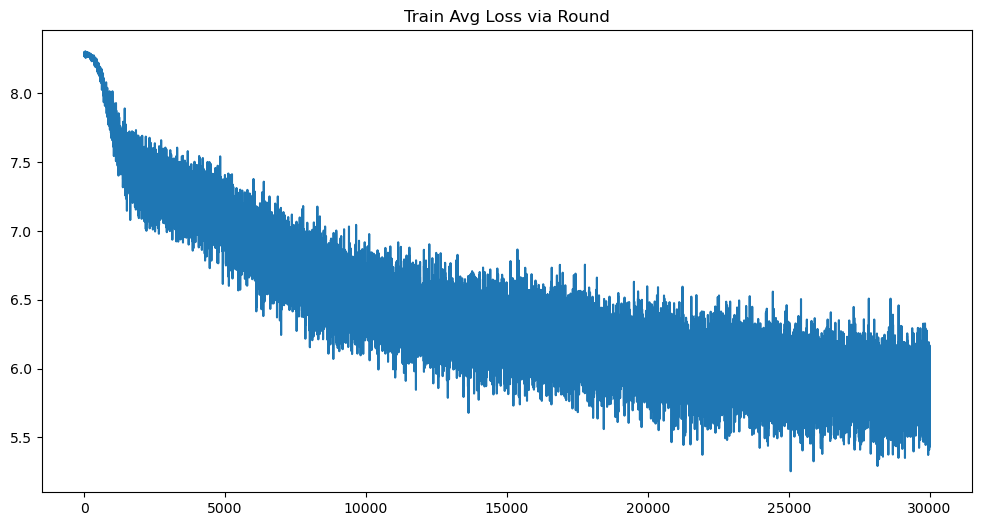

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## draw avg train loss plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(total_round_num), avg_train_loss, label='Average Train Loss')
plt.title("Train Avg Loss via Round")
plt.show()



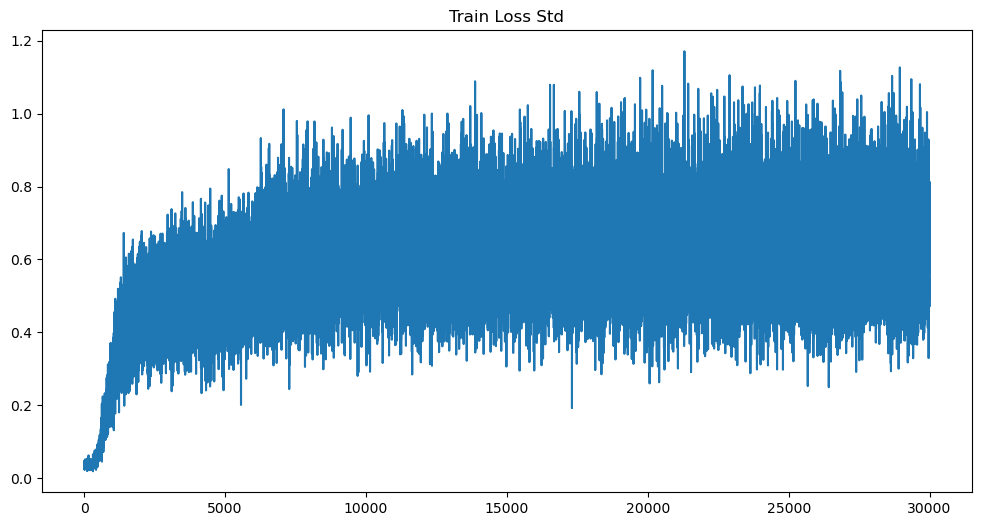

In [48]:
## draw train std loss plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(total_round_num), std_train_loss, label='Train Loss Std')
plt.title("Train Loss Std")
plt.show()



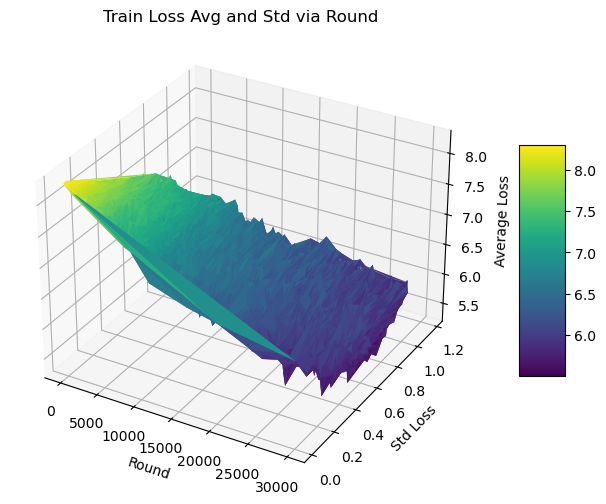

In [49]:
## draw 3d plot of std and avg via round

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

x = range(total_round_num)
z = avg_train_loss
y = std_train_loss

surf = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')
ax.set_title("Train Loss Avg and Std via Round")
ax.set_xlabel("Round")
ax.set_ylabel("Std Loss")
ax.set_zlabel("Average Loss")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()





